# KLASYFIKACJA GATUNKU MUZYCZNEGO
Zadanie to ma polegać na przewidzeniu jakiego gatunku jest utwór. Wstępne przygotowanie danych jest analogiczne do tego co było w części związej z predykcją. 

In [55]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
data = pd.read_csv('dane_po_EDA.csv')

In [57]:
data.drop([data.columns[0]], axis=1, inplace=True)

In [58]:
data.drop(columns=['track', 'artist', 'album'], inplace=True)

In [59]:
filt = data['new genre'] != 'Other'
data = data[filt]

In [60]:
data

,artist pop,track pop,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,new genre
0,87,71,186466,0.680,0.609,-5.222,0.0440,0.323000,0.000000,0.1020,0.325,94.350,2016,pop
1,80,83,276920,0.491,0.956,-1.538,0.3920,0.029500,0.000000,0.4600,0.811,173.585,2009,hip hop
2,82,81,265480,0.216,0.497,-8.025,0.0371,0.128000,0.000002,0.1110,0.313,187.308,2019,hip hop
3,86,81,291796,0.421,0.131,-18.435,0.0382,0.952000,0.004530,0.1090,0.120,137.446,2019,pop
4,81,80,354320,0.411,0.404,-9.928,0.0511,0.271000,0.000000,0.3000,0.226,71.068,1975,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,68,73,294600,0.320,0.880,-6.035,0.0504,0.000101,0.000004,0.0760,0.257,146.349,2001,metal
2118,53,61,236866,0.301,0.823,-4.072,0.0433,0.000144,0.000309,0.0833,0.372,152.017,2000,metal
2119,67,51,245306,0.479,0.929,-5.106,0.0921,0.002910,0.293000,0.1710,0.344,159.949,2005,rock
2120,78,76,285653,0.546,0.814,-5.146,0.0314,0.023000,0.000000,0.0972,0.146,104.980,2004,rock


In [61]:
def cor_features(df):
    highly_correlated_features = set()
    correlation_matrix = df.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] > 0.6:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                highly_correlated_features.add((colname_i, colname_j, correlation_matrix.iloc[i, j]))
    print("Pairs of highly correlated features:")
    for pair in highly_correlated_features:
        print(pair)


In [62]:
data_cor = data.drop([data.columns[13]], axis=1)
cor_features(data_cor)

Pairs of highly correlated features:
('acousticness', 'loudness', 0.6702157700395519)
('acousticness', 'energy', 0.7778653706571921)
('instrumentalness', 'loudness', 0.6734956210013407)
('loudness', 'energy', 0.7799460045774012)


In [63]:
columns_to_drop = ['instrumentalness', 'acousticness']
data.drop(columns=columns_to_drop, inplace=True)

## Label Encoder
Ponieważ chcemy przewidywac gatunek, musimy zamienić wartość string na liczbową, tak aby np. móc policzyć korelacje z innymi cechami. Wykorzystujemy do tego Label Encoder, który każdemu gatunkowi przyporządkowuje unikalną liczbę. 

In [64]:
from sklearn.preprocessing import LabelEncoder

genres = data['new genre']
label_encoder = LabelEncoder()
encoded_genres = label_encoder.fit_transform(genres)
print("Zakodowane gatunki:", encoded_genres)
for genre, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{genre}: {code}")
data.drop(columns='new genre', inplace=True)
data['genre'] = encoded_genres

Zakodowane gatunki: [ 9  4  4 ... 11 11  7]
blues: 0
classical: 1
dance: 2
folk: 3
hip hop: 4
indie: 5
jazz: 6
metal: 7
other: 8
pop: 9
rap: 10
rock: 11
soul: 12


### Podział danych testowych i treningowych.

In [65]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Standaryzacja danych.

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
X_train = x_train_scaled
X_test = x_test_scaled

# MODELE

# LOGISTIC REGRESSION

![MODEL](https://www.saedsayad.com/images/LogReg_1.png)

In [67]:
from sklearn.linear_model import LogisticRegression
model_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

# RANDOM FOREST CLASSIFIER 

Złożony model  składający się z wielu drzew decyzyjnych, gdzie każde drzewo przyczynia się do końcowej klasyfikacji, a decyzje są podejmowane na podstawie większości głosów (bagging).

![RF](https://miro.medium.com/v2/resize:fit:1358/1*i69vGs4AfhdhDUOlaPVLSA.png)

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model_rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  # różne wartości liczby drzew
    'max_depth': [3, 4, 5] # głębokość 
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Najlepsze parametry
print("Najlepsze parametry:", grid_search.best_params_)

# Najlepszy wynik
print("Najlepszy wynik:", grid_search.best_score_)

Najlepsze parametry: {'max_depth': 5, 'n_estimators': 200}
Najlepszy wynik: 0.5150296548776802


In [69]:
model_rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state=42)

# SVC

Algorytm klasyfikacji, który znajduje hiperpłaszczyznę najlepiej oddzielającą klasy w przestrzeni wielowymiarowej, maksymalizując margines między najbliższymi punktami danych z różnych klas (zwanymi wektorami wspierającymi).


![SVC](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288454/index2_ub1uzd.png)

In [70]:
from sklearn.svm import SVC
model_svc = SVC(kernel='rbf', random_state=42)

# KNN

Algorytm klasyfikacji, który klasyfikuje nowy punkt danych na podstawie większościowej klasy jego k najbliższych sąsiadów w przestrzeni cech, gdzie k jest ustaloną liczbą sąsiadów.

Aby wybrać odpowiednią liczbę sąsiadów, obliczam dla różnych wartości accuracy (z pomocą k krotnej walidacji krzyżowej z podziałem na 3 foldy)g i wybieram taką liczbę, dla której accuracy jest największe.


![KNN](https://miro.medium.com/v2/resize:fit:1400/0*ItVKiyx2F3ZU8zV5)

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


k_range = range(1, 30)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Obliczenie średniej dokładności przy użyciu walidacji krzyżowej
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    k_scores.append(scores.mean())

for i, score in enumerate(k_scores):
    print(f"k={k_range[i]}, Accuracy={score:.4f}")


k=1, Accuracy=0.4637
k=2, Accuracy=0.4148
k=3, Accuracy=0.4390
k=4, Accuracy=0.4484
k=5, Accuracy=0.4496
k=6, Accuracy=0.4579
k=7, Accuracy=0.4484
k=8, Accuracy=0.4608
k=9, Accuracy=0.4750
k=10, Accuracy=0.4820
k=11, Accuracy=0.4844
k=12, Accuracy=0.4820
k=13, Accuracy=0.4814
k=14, Accuracy=0.4838
k=15, Accuracy=0.4779
k=16, Accuracy=0.4744
k=17, Accuracy=0.4714
k=18, Accuracy=0.4862
k=19, Accuracy=0.4797
k=20, Accuracy=0.4803
k=21, Accuracy=0.4809
k=22, Accuracy=0.4838
k=23, Accuracy=0.4826
k=24, Accuracy=0.4850
k=25, Accuracy=0.4879
k=26, Accuracy=0.4873
k=27, Accuracy=0.4897
k=28, Accuracy=0.4820
k=29, Accuracy=0.4785


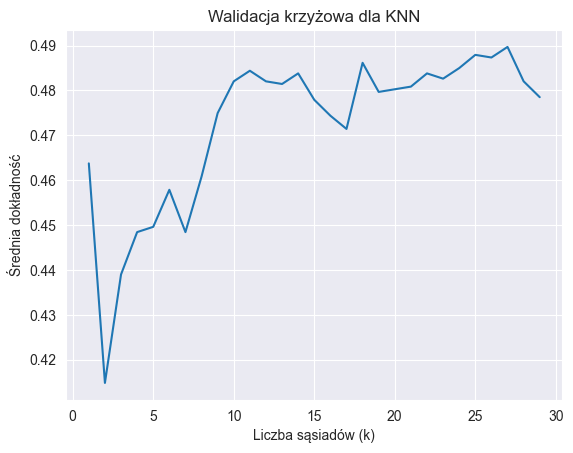

In [72]:
plt.plot(k_range, k_scores)
plt.xlabel('Liczba sąsiadów (k)')
plt.ylabel('Średnia dokładność')
plt.title('Walidacja krzyżowa dla KNN')
plt.show()

In [73]:
k = 22 
model_knn = KNeighborsClassifier(k)

# XGBOOST

Zaawansowany model wykorzystujący gradient boosting, który iteracyjnie dodaje drzewa decyzyjne w celu minimalizacji funkcji kosztu, optymalizując dokładność przewidywań poprzez ukierunkowane poprawki do wcześniejszych błędów.

![xgb](https://miro.medium.com/v2/resize:fit:1000/0*zdmqFZ2nooBRedqC.png)

In [74]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

model_xgb = XGBClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], random_state=42)

Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best score: 0.5680592472143178


# MLP
Mała sieć neuronowa zakodowana poniżej składa się z wejścia (11 cech), 4 warstw ukrytych (przy których jako funkcji aktywacji używamy sigmoidy) oraz warstwy wyjściowej, która składa się z 13 węzłów, gdyż tyle mamy klas (rodzajów gatunków). Przy wyjściu używamy funkcji softmax, która pozwala znormalizowanie prawdopodobieństw każdej klasy, które są wynikiem modelu. Wybieramy klasę, która ma największe prawdopodbieńśtwo. 
![mlp](https://rasbt.github.io/mlxtend/user_guide/classifier/NeuralNetMLP_files/neuralnet_mlp_1.png)

In [75]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

y_train = y_train.astype(float)
y_test = y_test.astype(float)

model_mlp = tf.keras.Sequential([
    tf.keras.Input(shape=(11,)),  # Warstwa wejściowa z 11 cechami
    tf.keras.layers.Dense(64, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(32, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(16, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(8, activation='sigmoid'),  # Ukryta warstwa
    tf.keras.layers.Dense(13, activation='softmax')  # Warstwa wyjściowa dla klasyfikacji binarnej
])

model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mlp = KerasClassifier(model=model_mlp, epochs=10, batch_size=32, verbose=0)

# Walidacja

Do walidajci używamy k krotną walidację krzyżową, jako metrykę względem której dokonujemy walidacji, wybraliśmy accuracy. 

In [76]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

kf = KFold(n_splits=3, shuffle=True, random_state=42)

def score_of_model(model):
    acc_score = []

    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(x_train_fold, y_train_fold)
        val_pred = model.predict(x_val_fold)
        acc = accuracy_score(y_val_fold, val_pred)
        acc_score.append(acc)
    return acc_score

validation_tab = pd.DataFrame(columns=['Model', 'Score 1', 'Score 2', 'Score 3'])
scores = [np.mean(score_of_model(model_lg)), np.mean(score_of_model(model_knn)), np.mean(score_of_model(model_svc)), np.mean(score_of_model(model_rf)), np.mean(score_of_model(model_xgb)), np.mean(score_of_model(model_mlp))]
models= ['logistic regression', 'KNN', 'SVC', 'random forest', 'XGBOOST', 'MLP']
validation_tab['Mean Score'] = scores
validation_tab['Model'] = models
validation_tab.iloc[0, 1:4] = score_of_model(model_lg)
validation_tab.iloc[1, 1:4] = score_of_model(model_knn)
validation_tab.iloc[2, 1:4] = score_of_model(model_svc)
validation_tab.iloc[3, 1:4] = score_of_model(model_rf)
validation_tab.iloc[4, 1:4] = score_of_model(model_xgb)
validation_tab.iloc[5, 1:4] = score_of_model(model_mlp)

validation_tab

,Model,Score 1,Score 2,Score 3,Mean Score
0,logistic regression,0.489399,0.498233,0.481416,0.489683
1,KNN,0.489399,0.466431,0.484956,0.480262
2,SVC,0.501767,0.489399,0.490265,0.493811
3,random forest,0.498233,0.508834,0.518584,0.508550
4,XGBOOST,0.537102,0.570671,0.541593,0.549789
5,MLP,0.379859,0.443463,0.470796,0.336514


# Learning Curve

C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
 

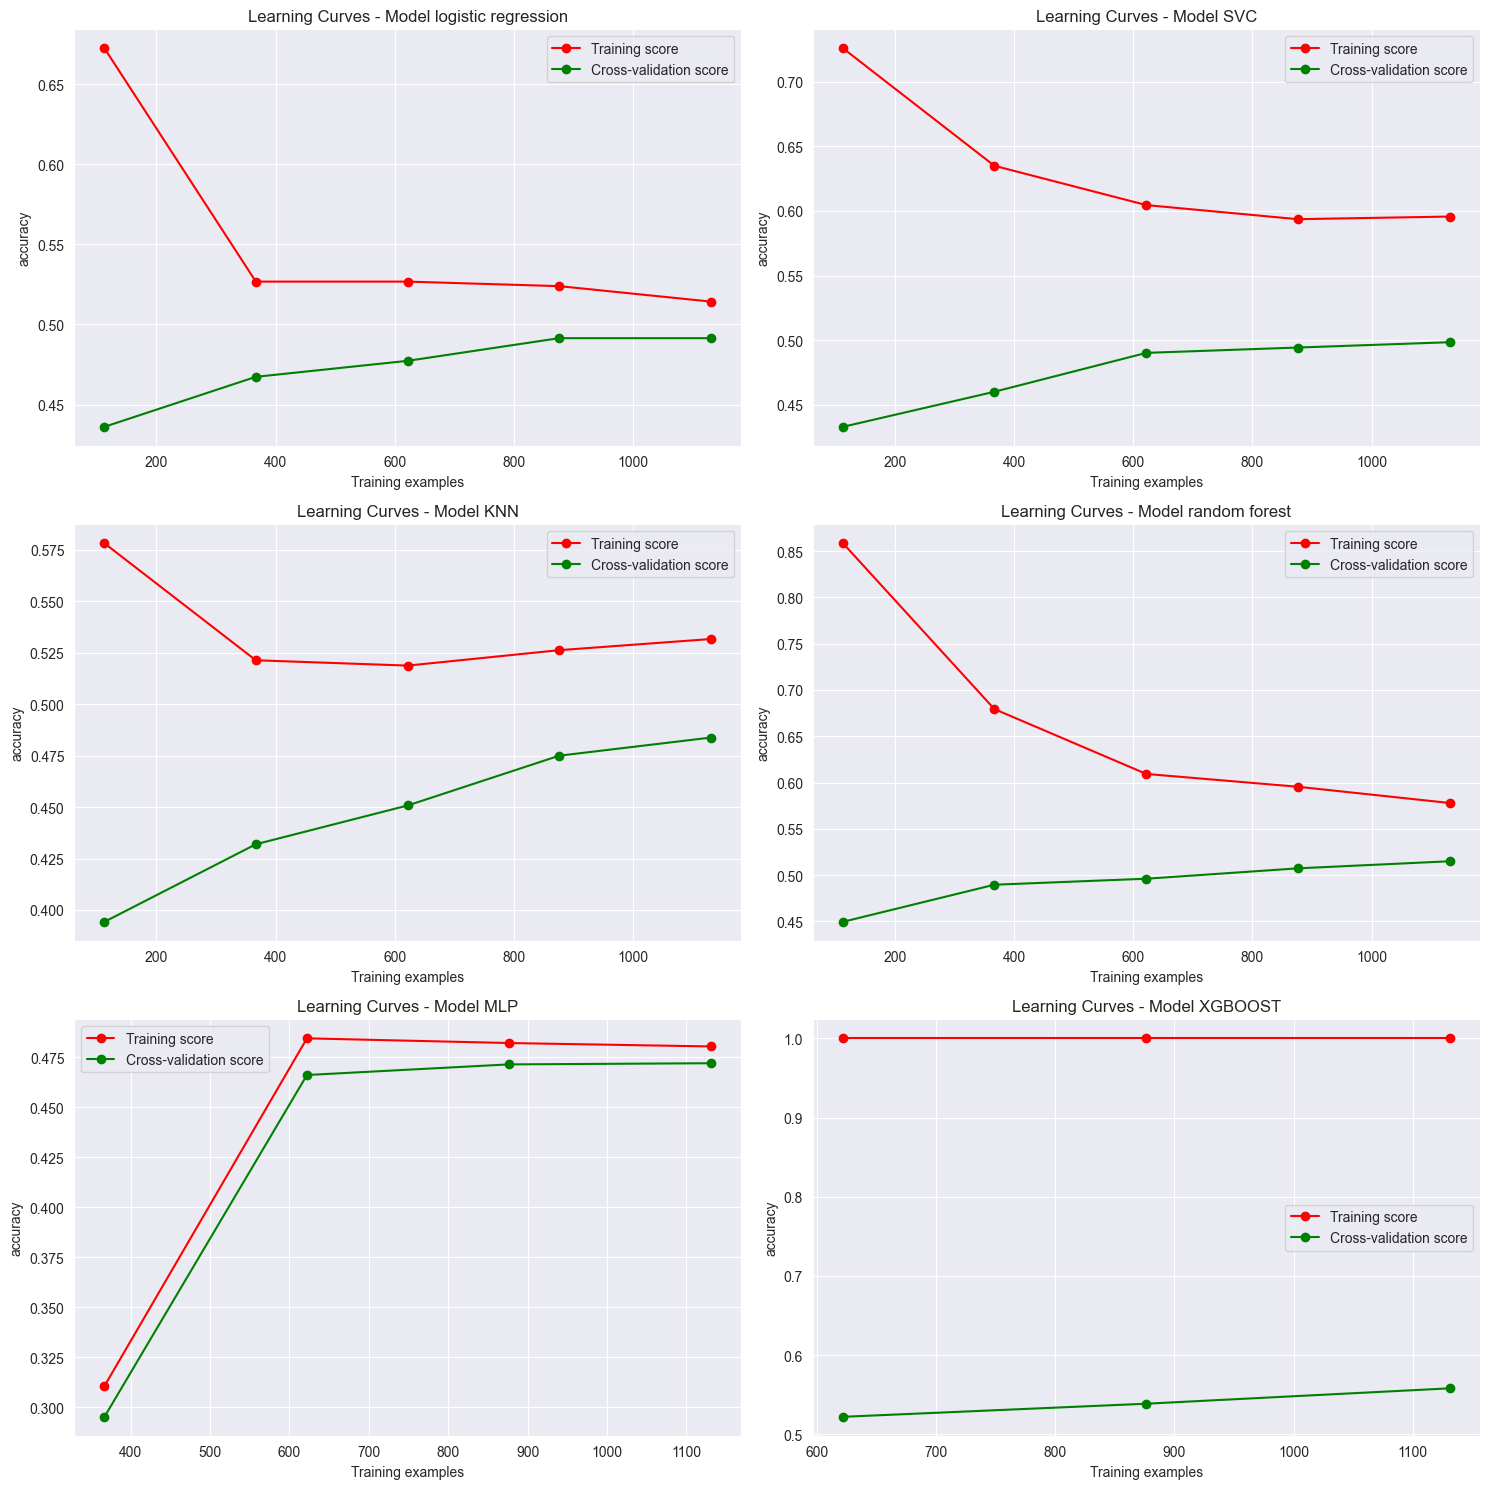

In [77]:
from sklearn.model_selection import learning_curve

def wykres_bledu(model, nazwa_modelu, ax, X=X_train, y=y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=3, scoring='accuracy')
    
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
    ax.set_title(f'Learning Curves - {nazwa_modelu}')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('accuracy')
    ax.legend(loc='best')

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

wykres_bledu(model_lg, 'Model logistic regression', axes[0, 0])
wykres_bledu(model_svc, 'Model SVC', axes[0, 1])
wykres_bledu(model_knn, 'Model KNN', axes[1, 0])
wykres_bledu(model_rf, 'Model random forest', axes[1, 1])
wykres_bledu(model_mlp,  'Model MLP', axes[2, 0])
wykres_bledu(model_xgb,  'Model XGBOOST', axes[2, 1])

plt.tight_layout()
plt.show()

# Ocena 
Do oceny używamy 4 wskaźników:
...

In [78]:
model_lg.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_svc.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

y_pred_lg = model_lg.predict(X_test)
y_pred_knn = model_knn.predict(X_test)
y_pred_svc = model_svc.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
predictions = model_mlp.predict(X_test)

lista_accuracy = [accuracy_score(y_test, y_pred_lg), accuracy_score(y_test, y_pred_knn),  accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, predictions)]
lista_precision = [precision_score(y_test, y_pred_lg, average='weighted'), precision_score(y_test, y_pred_knn, average='weighted'),  precision_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_xgb, average='weighted'), precision_score(y_test, predictions, average='weighted')]
lista_recall = [recall_score(y_test, y_pred_lg, average='weighted'), recall_score(y_test, y_pred_knn, average='weighted'),  recall_score(y_test, y_pred_svc,average='weighted' ), recall_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_xgb, average='weighted'), recall_score(y_test, predictions, average='weighted')]
lista_f1 = [f1_score(y_test, y_pred_lg, average='weighted'), f1_score(y_test, y_pred_knn, average='weighted'),  f1_score(y_test, y_pred_svc, average='weighted'), f1_score(y_test, y_pred_rf, average='weighted'), f1_score(y_test, y_pred_xgb, average='weighted'), f1_score(y_test, predictions, average='weighted')]
models= ['logist regression', 'KNN', 'SVC', 'random forest', 'XGBOOST', 'MLP']

error_tab  = pd.DataFrame()
error_tab['Model'] = models
error_tab['accuracy'] = lista_accuracy
error_tab['precision'] = lista_precision
error_tab['recall'] = lista_recall
error_tab['f1'] = lista_f1

C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\PycharmProjects\spotify_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [79]:
error_tab

,Model,accuracy,precision,recall,f1
0,logist regression,0.487059,0.455270,0.487059,0.453991
1,KNN,0.498824,0.476536,0.498824,0.453063
2,SVC,0.498824,0.428009,0.498824,0.442741
3,random forest,0.498824,0.413498,0.498824,0.437188
4,XGBOOST,0.578824,0.586585,0.578824,0.566319
5,MLP,0.456471,0.331538,0.456471,0.381567


In [80]:
def cm_plot(cm):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [81]:
from sklearn.metrics import roc_curve, auc

def aoc_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

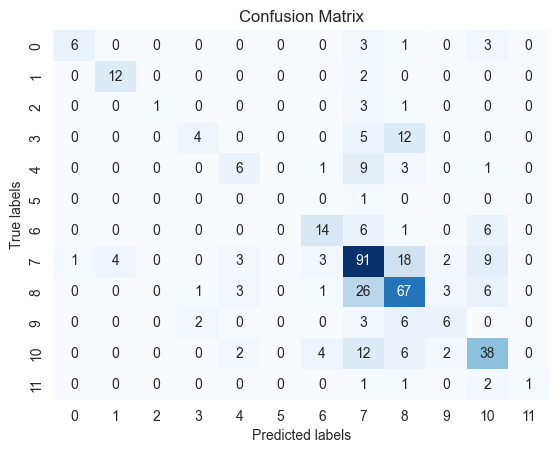

In [82]:
from sklearn import metrics

cm1 = metrics.confusion_matrix(y_test, y_pred_xgb)
cm_plot(cm1)

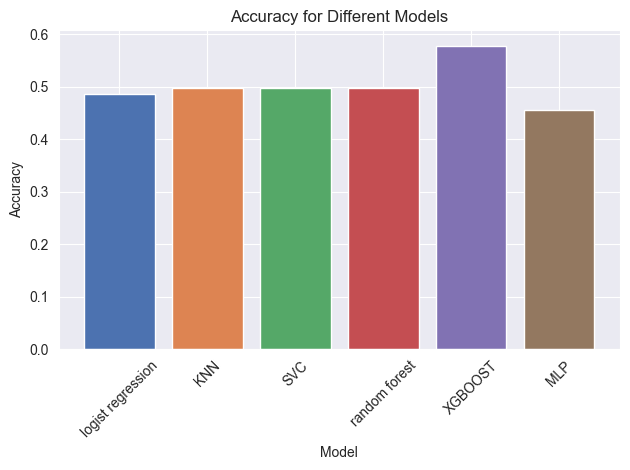

In [83]:
palette = sns.color_palette("deep", len(error_tab))
plt.bar(error_tab['Model'], error_tab['accuracy'], color=palette)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()

# Podsumowanie wyników
Jak widać accuracy największa jest dla XGBOOST i wynosi zaledwie 0.58. Problem w tym zadaniu jest taki, że w Spotify każda piosenka ma kilka przypisanych do siebie gatunków. Podczas pobierania danych, pobieraliśmy pierwszy z listy gatunek dla każdej z piosenek, co może być problemem przy klasyfikacji, gdyż nie są to jednoznaczne klasy. Dodatkowo gatunki są bardzo różne np. barbadian pop. My dla uproszczenia modeli przyjmowaliśmy taki gatunek jako pop, co niekoniecznie musi świdczyć, że ma on charakterystyczne cechy dla piosenek oryginalnie przyporządkowanych do gatunku pop. Wymienione aspekty mogą powodować, iż modele klasyfikacji nie będą w stanie dobrze określać gatunku piosenki. 